In [1]:
#conv Neural Network
# tensorboard --logdir=/home/ncc/notebook/learn/tensorboard/log
"""
created by kim Seong jung

"""
import numpy as np 
import tensorflow as tf
import re

import math
import time
import matplotlib.pyplot as plt
%matplotlib inline
import os 

from  PIL import Image 

# Load Image 

In [2]:

file_locate='./eye_numpy_64/'
#file_locate ='/media/seongjung/Seagate Backup Plus Drive/data/Eye/npy/npy_128/'
sess = tf.InteractiveSession()
test_img=np.load(file_locate+'test_img.npy');
test_lab=np.load(file_locate+'test_lab.npy');
try:
    print np.shape(test_img)
    print np.shape(test_lab)
    img_row = np.shape(test_img)[1]
    img_col = np.shape(test_img)[2]
except:
    np.shape(test_img)
    test_img=np.reshape(test_img , newshape = [np.shape(test_img)[0] , 32, 32 ,3] )
    img_row = np.shape(test_img)[1]
    img_col = np.shape(test_img)[2]

    
divide_flag= True
aug_type = True


(2789, 128, 128, 3)
(2789, 2)


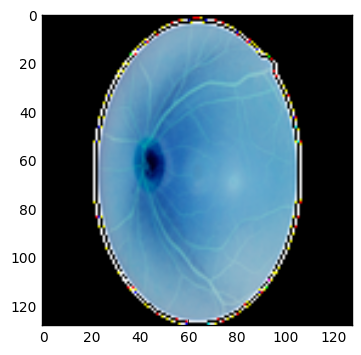

In [22]:
test_img_lr=np.fliplr(test_img)
test_img_ud=np.flipud(test_img)
img0=test_img[0,:,:,:]
img1=test_img_lr[0,:,:,:]
img2=test_img_ud[0,:,:,:]
plt.imshow(img0)





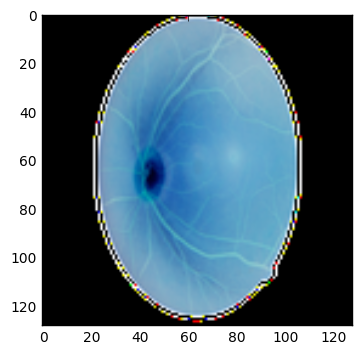

In [18]:
plt.imshow(img1)

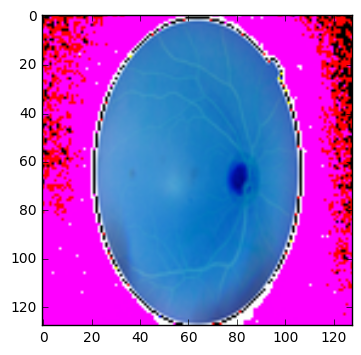

In [21]:
plt.imshow(img2)

In [38]:
def aug_8times(x):
    """
    x shape is [n_batch , row ,col , color_ch ]
    x type is numpy 
    this code need too many time to run 
    we should find solution using parallel method to less run time maybe 
    """
    start_time =time.time()
    n_batch,row,col,ch=np.shape(x)
    lr_x = np.flipud(x)

    np_rot90 =np.zeros(shape =[n_batch , row ,col ,ch] )
    np_rot180=np.zeros(shape =[n_batch , row ,col ,ch] )
    np_rot270=np.zeros(shape =[n_batch , row ,col ,ch] )

    np_lr_rot90 =np.zeros(shape =[n_batch , row ,col ,ch] )
    np_lr_rot180=np.zeros(shape =[n_batch , row ,col ,ch] )
    np_lr_rot270=np.zeros(shape =[n_batch , row ,col ,ch] )
    
    

    for batch_ind in range(n_batch):

        rot90=np.rot90(x[batch_ind,:,:,:])
        rot180=np.rot90(rot90)
        rot270=np.rot90(rot180)

        np_rot90[batch_ind,:,:,:] = rot90
        np_rot180[batch_ind,:,:,:]=rot180
        np_rot270[batch_ind,:,:,:]=rot270

        lr_rot90=np.rot90(lr_x[batch_ind,:,:,:])
        lr_rot180=np.rot90(lr_rot90)
        lr_rot270=np.rot90(lr_rot180)

        np_lr_rot90[batch_ind,:,:,:]=lr_rot90
        np_lr_rot180[batch_ind,:,:,:]=lr_rot180
        np_lr_rot90[batch_ind,:,:,:]=lr_rot270
    end_time =time.time()
    print end_time - start_time
    return x,np_rot90,np_rot180,np_rot270,lr_x,np_lr_rot90 ,np_lr_rot180 , np_lr_rot270 

In [39]:
x,np_rot90,np_rot180,np_rot270,lr_x,np_lr_rot90 ,np_lr_rot180 , np_lr_rot270 =aug_8times(test_img)

4.36177682877


# load Training , Validation , Test 

In [3]:
with tf.device('/gpu:0'):
#with tf.device('/gpu:0'):
    if divide_flag == False:
        train_img=np.load(file_locate+'train_img.npy');
        train_lab=np.load(file_locate+'train_lab.npy');
        val_img= np.load(file_locate+'val_img.npy');
        val_lab = np.load(file_locate+'val_lab.npy');
        test_img=np.load(file_locate+'test_img.npy');
        test_lab=np.load(file_locate+'test_lab.npy');

        print "Training Data",np.shape(train_img)
        print "Training Data Label",np.shape(train_lab)
        print "Test Data Label",np.shape(test_lab)
        print "val Data Label" , np.shape(val_img)

        n_train= np.shape(train_img)[0]
        n_train_lab = np.shape(train_lab)[0]

    if divide_flag == True:
        train_img=np.load(file_locate+'train_img.npy');
        train_lab=np.load(file_locate+'train_lab.npy');
        val_img= np.load(file_locate+'val_img.npy');
        val_lab = np.load(file_locate+'val_lab.npy');
        test_img=np.load(file_locate+'test_img.npy');
        test_lab=np.load(file_locate+'test_lab.npy');

        print "Training Data",np.shape(train_img)
        print "Training Data Label",np.shape(train_lab)
        print "Test Data Label",np.shape(test_lab)
        print "val Data Label" , np.shape(val_lab)

        n_train= np.shape(train_img)[0]
        n_train_lab = np.shape(train_lab)[0]


Training Data (22302, 128, 128, 3)
Training Data Label (22302, 2)
Test Data Label (2789, 2)
val Data Label (2787, 2)


In [4]:
in_ch =3
n_classes=2

In [5]:
with tf.device('/gpu:0'):
    def next_batch(batch_size , image , label):

        a=np.random.randint(np.shape(image)[0] -batch_size)
        batch_x = image[a:a+batch_size,:]
        batch_y= label[a:a+batch_size,:]
        return batch_x, batch_y


# define Variable , and placeholder 

In [6]:

x = tf.placeholder("float",shape=[None,img_row , img_col , in_ch],  name = 'x-input')
y_= tf.placeholder("float",shape=[None , n_classes] , name = 'y-input')
keep_prob = tf.placeholder("float")
x_image= tf.reshape(x,[-1,img_row,img_col,3])



In [7]:
"""def weight_variable(name,shape):
    #initial = tf.truncated_normal(shape , stddev=0.1)
    initial = tf.get_variable(name,shape=shape , initializer = tf.contrib.layers.xavier_initializer())
    return tf.Variable(initial)"""

def bias_variable(shape):
    initial = tf.constant(0.1 , shape=shape)
    return tf.Variable(initial)



In [8]:


def conv2d(x,w,strides_):
    return tf.nn.conv2d(x,w, strides = strides_, padding='SAME')
def max_pool_2x2(x):
    return tf.nn.max_pool(x , ksize=[1,2,2,1] ,strides = [1,2,2,1] , padding = 'SAME')
def max_pool(x , ksize , strides , padding='SAME'):
    return tf.nn.max_pool(x ,ksize , strides , padding )
def make_weights_biases(layer_name , w_name , ksize ,device_name,initializer='xavier'):
    if len(ksize)==4: # convolution filter shape [batch , row , col , color_ch]
        out_ch=ksize[3]
    elif len(ksize)==2: #fully connected layer shape [in_ch , output_ch]
        out_ch=ksize[1]
    with tf.device(device_name):
        with tf.variable_scope(layer_name) as scope:
            try:
                w_conv = tf.get_variable(w_name, ksize , initializer = tf.contrib.layers.xavier_initializer())
            except:
                scope.reuse_variables()
                w_conv = tf.get_variable(w_name, ksize , initializer = tf.contrib.layers.xavier_initializer())
        
        with tf.variable_scope(layer_name) as scope:
            try:
                b_conv = bias_variable([out_ch])
            except:
                scope.reuse_variables()
                b_conv = bias_variable([out_ch])
    return w_conv , b_conv 



In [9]:
def STEM_A(x , device_):
    with tf.device(device_):
        in_ch=x.get_shape()[3]
        out_ch1=32 ; out_ch2=32;out_ch3=64;out_ch4=96;

        c_ksize1=[3,3,in_ch , out_ch1]
        c_ksize2=[3,3,out_ch1 , out_ch2]
        c_ksize3=[3,3,out_ch2 , out_ch3]
        c_ksize4=[3,3,out_ch3 , out_ch4]
        w_conv1 , b_conv1 =make_weights_biases('STEM_A' , 'W1' , c_ksize1 ,device_name = '/gpu:0')
        w_conv2 , b_conv2= make_weights_biases('STEM_A' , 'W2' , c_ksize2 ,device_name = '/gpu:0')
        w_conv3 , b_conv3= make_weights_biases('STEM_A' , 'W3' , c_ksize3 ,device_name = '/gpu:0')
        w_conv4 , b_conv4= make_weights_biases('STEM_A' , 'W4' , c_ksize4 ,device_name = '/gpu:0')

        c_strides1=[1,2,2,1]
        c_strides2=[1,1,1,1]
        c_strides3=[1,1,1,1]
        c_strides4=[1,2,2,1]

        c_pooling1='VALID'
        c_pooling2='VALID'
        c_pooling3='SAME'
        c_pooling4='VALID'

        b_p_ksize4=[1,3,3,1]
        b_p_strides4=[1,2,2,1]
        b_p_padding4 ='VALID'



        layer1=tf.nn.conv2d(    x ,      w_conv1, c_strides1, c_pooling1  )+b_conv1
        layer1=tf.nn.relu(layer1)
        layer2=tf.nn.conv2d(    layer1 , w_conv2, c_strides2, c_pooling2  )+b_conv2
        layer2=tf.nn.relu(layer2)
        layer3=tf.nn.conv2d(    layer2 , w_conv3, c_strides3, c_pooling3  )+b_conv3
        layer3=tf.nn.relu(layer3)
        layer4=tf.nn.conv2d(    layer3 , w_conv4, c_strides4, c_pooling4  )+b_conv4
        layer4=tf.nn.relu(layer4)


        b_layer4=tf.nn.max_pool(layer3 , b_p_ksize4, b_p_strides4, b_p_padding4 ) #b is branch
        b_layer4=tf.nn.relu(b_layer4)
        print layer1
        print layer2
        print layer3
        print layer4
        print b_layer4


        concat_layer=tf.concat(3 , [layer4 , b_layer4])
        ret_layer=concat_layer
        print concat_layer
        return ret_layer

In [10]:
def STEM_B( x , device_):
    with tf.device(device_):
        in_ch=x.get_shape()[3]


        #########################################################################
        out_ch1=64 ; out_ch2=64;out_ch3=64;out_ch4=96;
        ##############################right side##################################
        c_ksize1=[1,1,in_ch , out_ch1]
        c_ksize2=[7,1,out_ch1 , out_ch2]
        c_ksize3=[1,7,out_ch2 , out_ch3]
        c_ksize4=[3,3,out_ch3 , out_ch4]

        w_conv1 , b_conv1 =make_weights_biases('STEM_B' , 'W1' , c_ksize1 ,device_name = '/gpu:0')
        w_conv2 , b_conv2= make_weights_biases('STEM_B' , 'W2' , c_ksize2 ,device_name = '/gpu:0')
        w_conv3 , b_conv3= make_weights_biases('STEM_B' , 'W3' , c_ksize3 ,device_name = '/gpu:0')
        w_conv4 , b_conv4= make_weights_biases('STEM_B' , 'W4' , c_ksize4 ,device_name = '/gpu:0')

        c_strides1=[1,1,1,1]
        c_strides2=[1,1,1,1]
        c_strides3=[1,1,1,1]
        c_strides4=[1,1,1,1]

        c_pooling1='SAME'
        c_pooling2='SAME'
        c_pooling3='SAME'
        c_pooling4='VALID'

        ##############################left side##################################
        out_ch1=64 ; out_ch2=96;    
        #########################################################################
        b_c_ksize1=[1,1,in_ch , out_ch1]
        b_c_ksize2=[3,3,out_ch1 , out_ch2]
        b_w_conv1 , b_b_conv1 =make_weights_biases('STEM_B' , 'b_W1' , b_c_ksize1 ,device_name = '/gpu:0')
        b_w_conv2 , b_b_conv2= make_weights_biases('STEM_B' , 'b_W2' , b_c_ksize2 ,device_name = '/gpu:0')

        b_c_strides1=[1,1,1,1]
        b_c_strides2=[1,1,1,1]

        b_c_pooling1='SAME'
        b_c_pooling2='VALID'


        ##############################convolution ##################################
        layer1 = tf.nn.conv2d(x ,      w_conv1 , c_strides1 , c_pooling1)+b_conv1
        layer1 = tf.nn.relu(layer1)
        layer2 = tf.nn.conv2d(layer1 , w_conv2 , c_strides2 , c_pooling2)+b_conv2
        layer2 = tf.nn.relu(layer2)
        layer3 = tf.nn.conv2d(layer2 , w_conv3 , c_strides3 , c_pooling3)+b_conv3
        layer3 = tf.nn.relu(layer3)
        layer4 = tf.nn.conv2d(layer3 , w_conv4 , c_strides4 , c_pooling4)+b_conv4
        layer4 = tf.nn.relu(layer4)

        b_layer1 =tf.nn.conv2d(    x ,      b_w_conv1, b_c_strides1, b_c_pooling1  ) + b_b_conv1
        b_layer1 = tf.nn.relu(layer1)
        b_layer2=tf.nn.conv2d(  b_layer1 , b_w_conv2, b_c_strides2, b_c_pooling2  ) + b_b_conv2

        ##############################concatenate layers###########################
        concat_layer=tf.concat(3 , [layer4 , b_layer2])
        ret_layer=concat_layer
    return ret_layer

In [11]:
def STEM_C( x , device_ ):
    with tf.device(device_):
        in_ch=x.get_shape()[3]
        out_ch1 = 192


        c_ksize=[3,3,in_ch,out_ch1]
        w_conv , b_conv =make_weights_biases('STEM_C' , 'W1' , c_ksize ,device_name = '/gpu:0')
        c_strides=[1,1,1,1]
        c_pooling='SAME'

        b_p_ksize=[1,2,2,1]
        b_p_strides=[1,1,1,1]
        b_p_pooling='SAME'

        layer1 = tf.nn.conv2d(x , w_conv   , c_strides   , c_pooling)+b_conv
        layer1 = tf.nn.relu(layer1)
        b_layer1 = tf.nn.max_pool(x , b_p_ksize , b_p_strides , b_p_pooling)
        b_layer1 = tf.nn.relu(b_layer1)

        print layer1
        print b_layer1

        concat_layer=tf.concat(3,[layer1 , b_layer1])
        ret_layer = concat_layer
    return ret_layer

In [12]:
def FLAT(x):
    
    row=int(x.get_shape()[1])
    col=int(x.get_shape()[2])
    ch=int(x.get_shape()[3])
    
    res_x = tf.reshape(x , shape=[-1,row*col*ch])
    return res_x
    #connect fully connected layer 

In [13]:
def FC_A(x , n_classes , device_ , device_2= '/gpu:4'):
    with tf.device(device_):
    
        fully_ch1=1024; fully_ch2=1024

        fc_ksize1=[x.get_shape()[1],fully_ch1]
        fc_ksize2=[fully_ch1,fully_ch2]

        w_fc1 ,b_fc1 = make_weights_biases('fc1' , 'fc_W1' , fc_ksize1 ,  device_)
        w_fc2 ,b_fc2 = make_weights_biases('fc2' , 'fc_W2' , fc_ksize2 ,  device_2)

        h_fc1=tf.matmul(x, w_fc1 )+b_fc1
        h_fc1=tf.nn.dropout(h_fc1 , keep_prob)
        h_fc2=tf.matmul(h_fc1 , w_fc2 )+b_fc2
        h_fc2=tf.nn.dropout(h_fc2 , keep_prob)
        end_fc=h_fc2

        end_ksize=[end_fc.get_shape()[1] , n_classes]   
        w_end ,b_end = make_weights_biases('fc_end' , 'fc_end_W' , end_ksize ,  device_2)
        y_conv = tf.matmul(end_fc , w_end)+b_end

        print w_fc1.get_shape()
    return y_conv
    

In [14]:
def FC_B(x , n_classes , device_ ):
    with tf.device(device_):

        end_ksize=[x.get_shape()[1] , n_classes]   
        w_end ,b_end = make_weights_biases('fc_end' , 'fc_end_W' , end_ksize ,  '/gpu:0')
        y_conv = tf.matmul(x , w_end)+b_end

   
    return y_conv

In [15]:
def INCEPTION_MODULE_A(x , device_):

    """
    input X shape is [n_batch , row , col, out_ch]
    35 x 35 grid
    """

    #################################################################################
    in_ch=x.get_shape()[3]
    out_ch1=64 ; out_ch2= 96;
    c_ksize1 = [1 , 1 ,in_ch , out_ch1 ]
    c_ksize2 = [3 , 3 ,in_ch , out_ch2 ]
    w_conv1 , b_conv1 = make_weights_biases ('INCEPTION_MODULE_A' , 'W1' , c_ksize1 ,device)
    w_conv2 , b_conv2 = make_weights_biases('INCEPTION_MODUEL_A' ,'W1' , c_ksize2 ,device)

    c_strides1=[1,1,1,1]
    c_strides2=[1,1,1,1]
    layer1 = tf.nn.conv2d(x , w_conv1 , c_strides1 ,device_ )
    layer2 = tf.nn.conv2d(layer1 , w_conv2 , c_strides2 ,device_ )

    #################################################################################                     

    b1_p_ksize   =[1,2,2,1]
    b1_p_strides =[1,1,1,1]
    b1_p_pooling='SAME'


    b1_out_ch = 96;
    b1_c_ksize  =[1,1, in_ch , b1_out_ch]
    b1_c_strides=[1,1,1,1]
    b1_c_pooling ='SAME'

    b1_w_conv , b1_b_conv =make_weights_biases('INCEPTION_MODULE_A','b1_W',b1_c_ksize , device)


    b1_layer1=tf.nn.avg_pool(x, b1_p_ksize , b1_p_strides,b1_c_pooling)
    b1_layer1=tf.nn.relu(b1_layer1)
    b1_layer2=tf.nn.conv2d(b1_layer1 , b1_w_conv , b1_c_strides , b1_c_pooling)+b1_b_conv
    b1_layer2=tf.nn.relu(b1_layer2)

    #################################################################################                     

    b2_out_ch=96
    b2_c_ksize = [1,1,in_ch , b2_out_ch1 ]
    b2_w_conv , b2_b_conv = make_weights_biases('INCEPTION_MODULE_A','b2_W',b2_c_ksize , device)
    b2_c_strides=[1,1,1,1]
    b2_c_pooling='SAME'

    b2_layer = tf.nn.conv2d( x, b2_w_conv , b2_c_strides ,b2_pooling ) +b2_b_conv 
    b2_layer = tf.nn.relu(b2_layer)



    #################################################################################                     


    b3_out_ch1=64;b3_out_ch2=96;b3_out_ch3=96;
    b3_c_ksize1 =[1,1,in_ch , b3_out_ch1]
    b3_c_ksize2 =[3,3,b3_out_ch1 , b3_out_ch2]
    b3_c_ksize3 =[3,3,b3_out_ch2 , b3_out_ch3]
    b3_w_conv1 , b3_b_conv1 = make_weights_biases('INCEPTION_MODULE_A','b3_W1',b3_c_ksize1 , device)
    b3_w_conv2 , b3_b_conv2 = make_weights_biases('INCEPTION_MODULE_A','b3_W2',b3_c_ksize2 , device)
    b3_w_conv3 , b3_b_conv3 = make_weights_biases('INCEPTION_MODULE_A','b3_W3',b3_c_ksize3 , device)
    b3_c_strides1=[1,1,1,1]
    b3_c_strides2=[1,1,1,1]
    b3_c_strides3=[1,1,1,1]
    b3_c_pooling1='SAME'
    b3_c_pooling2='SAME'
    b3_c_pooling3='SAME'

    b3_laer1 = tf.nn.conv2d(x , b3_w_conv1 , b3_c_strides1 ,b3_c_pooling1)+b3_b_conv1 
    b3_layer1 = tf.nn.relu(layer1)
    b3_layer2 = tf.nn.conv2d(layer1 , b3_w_conv1 , b3_c_strides1 ,b3_c_pooling1)+b3_b_conv2 
    b3_layer2 = tf.nn.relu(layer2)
    b3_layer3 = tf.nn.conv2d(layer2 , b3_w_conv1 , b3_c_strides1 ,b3_c_pooling1)+b3_b_conv3 
    b3_layer3 = tf.nn.relu(layer3)

    #################################################################################                     
    concat_A=tf.concat(3,layer2 , b1_layer2)
    concat_B=tf.concat(3,concat_A , b2_layer2)
    concat_C=tf.concat(3,concat_B , b3_layer3)

    return concat_C

    #################################################################################                     





In [16]:
def INCEPTION_MODULE_B(x , device):

    """
    for 17 X 17 grid 
    """
    out_ch1 =192 ; out_ch2=224; out_ch3 =256
    c_size1 = [1,1, in_ch  ,out_ch1]
    c_size2 = [1,7, out_ch1,out_ch2]
    c_size3 = [7,1, out_ch2,out_ch3]

    w_conv1 , b_conv1 =make_weights_biases('INCEPTION_MODULE_B' ,'W1' ,  c_ksize1 , device)
    w_conv2 , b_conv2 =make_weights_biases('INCEPTION_MODULE_B' ,'W2' ,  c_ksize2 , device)
    w_conv3 , b_conv3 =make_weights_biases('INCEPTION_MODULE_B' ,'W3' ,  c_ksize3 , device)
    c_strides1 =[1,1,1,1]
    c_strides2 =[1,1,1,1]
    c_strides2 =[1,1,1,1]
    c_pooling1 ='SAME'
    c_pooling2 ='SAME'
    c_pooling3 ='SAME'


    layer1 = tf.nn.conv2d(x, w_conv1,c_strides1 , c_pooling1 ) +b_conv1
    layer1 = tf.nn.relu(layer1)
    layer2 = tf.nn.conv2d(layer2, w_conv2,c_strides2 , c_pooling2 ) +b_conv2
    layer2 = tf.nn.relu(layer2)
    layer3 = tf.nn.conv2d(layer2, w_conv3,c_strides3 , c_pooling3 ) +b_conv3
    layer3 = tf.nn.relu(layer3)


    ################################################################################# 


    b1_p_ksize=[1,2,2,1]
    b1_p_strides=[1,1,1,1]
    b1_p_pooling ='SAME'

    b1_out_ch = 128
    b1_c_ksize=[1,1,in_ch,b1_out_ch]
    b1_w_conv , b1_b_conv = make_weights_biases('INCEPTION_MODULE_B','b1_W1',b1_c_ksize, device )
    b1_c_strides=[1,1,1,1]
    b1_c_pooling='SAME'


    b1_layer1=tf.nn.avg_pooling(x , b1_p_ksize , b1_p_strides , b1_p_pooling )
    b1_layer1=tf.nn.relu(layer1)
    b1_layer2 =tf.nn.conv2d(layer1 ,b1_w_conv , b1_c_strides, b1_c_pooling )+b1_b_conv 
    b1_layer2 =tf.nn.relu(layer2)

    ################################################################################# 
    b2_out_ch=384
    b2_p_ksize=[1,1,in_ch,b2_out_ch]
    b2_w_conv , b2_b_conv =make_weights_biases('INCEPTION_MODULE_B','b2_W1' ,b2_c_ksize , device)
    b2_layer = tf.nn.conv2d(x,b2_w_conv , b2_c_strides , b2_c_pooling)+b2_b_conv

    ################################################################################# 


    b3_out_ch1=192; b3_out_ch2 =192; b3_out_ch3=224 ; b3_out_ch4=224 ; b3_out_ch5 =256
    b3_c_ksize1=[1,1,in_ch,b3_out_ch1]
    b3_c_ksize2=[1,7,b3_out_ch1 , b3_out_ch2]
    b3_c_ksize3=[7,1,b3_out_ch2 , b3_out_ch3]
    b3_c_ksize4=[1,7,b3_out_ch3 , b3_out_ch4]
    b3_c_ksize5=[7,1,b3_out_ch4 , b3_out_ch5]

    b3_w_conv1 , b3_b_conv1=make_weights_biases('INCEPTION_MODULE_B','b3_W1',b3_c_ksize1, device)
    b3_w_conv2 , b3_b_conv2=make_weights_biases('INCEPTION_MODULE_B','b3_W2',b3_c_ksize2, device)
    b3_w_conv3 , b3_b_conv3=make_weights_biases('INCEPTION_MODULE_B','b3_W3',b3_c_ksize3, device)
    b3_w_conv4 , b3_b_conv4=make_weights_biases('INCEPTION_MODULE_B','b3_W4',b3_c_ksize4, device)
    b3_w_conv5 , b3_b_conv5=make_weights_biases('INCEPTION_MODULE_B','b3_W5',b3_c_ksize5, device)


    b3_layer1 = tf.nn.conv2d(x,b3_w_conv1 , b2_c_strides , b2_c_pooling)+b3_b_conv1
    b3_layer1 = tf.nn.relu(b3_layer1)
    b3_layer2 = tf.nn.conv2d(b3_layer1,b3_w_conv2 , b2_c_strides , b2_c_pooling)+b3_b_conv2
    b3_layer2 = tf.nn.relu(b3_layer2)
    b3_layer3 = tf.nn.conv2d(b3_layer2,b3_w_conv3 , b2_c_strides , b2_c_pooling)+b3_b_conv3
    b3_layer3 = tf.nn.relu(b3_layer3)
    b3_layer4 = tf.nn.conv2d(b3_layer3,b3_w_conv4 , b2_c_strides , b2_c_pooling)+b3_b_conv4
    b3_layer4 = tf.nn.relu(b3_layer4)
    b3_layer5 = tf.nn.conv2d(b3_layer4,b3_w_conv5 , b2_c_strides , b2_c_pooling)+b3_b_conv5
    b3_layer5 = tf.nn.relu(b3_layer5)

    ################################################################################# 


    layerA=tf.concat(3, layer3 , b1_layer2 )
    layerB=tf.concat(3, layerA , b2_layer )
    layerC=tf.concat(3, layerB , b3_layer5 )

    print layerC
    return layerC


In [17]:
def INCEPTION_MODULE_C(x , device):

    """
    for 8 X 8 grid modules
    """
    out_ch1 = 384 ; out_ch2_a =256 ;out_ch2_b = 256
    c_ksize1 = [1,1,in_ch , out_ch1]
    c_ksize2_a = [1,3,out_ch1 , out_ch2_a]
    c_ksize2_b = [3,1,out_ch2_a , out_ch2_b]
    w_conv1 ,b_conv1=make_weights_biases('INCEPTION_MODULE_C','W1', c_ksize1 ,device)
    w_conv2_a ,b_conv2_a=make_weights_biases('INCEPTION_MODULE_C','W2_a', c_ksize2_a ,device)
    w_conv2_b ,b_conv2_b=make_weights_biases('INCEPTION_MODULE_C','W2_a', c_ksize2_b ,device)
    c_strides1=[1,1,1,1]
    c_strides2_a=[1,1,1,1]
    c_strides2_b=[1,1,1,1]
    c_pooling1='SAME'
    c_pooling2_a='SAME'
    c_pooling2_b='SAME'

    layer1 = tf.nn.conv2d(x, w_conv1 ,c_strides )+b_conv1
    layer1=tf.nn.relu(layer1)
    layer2_a = tf.nn.conv2d(layer1,  w_conv2_a ,c_strides2_a ,c_pooling2_a )+b_conv2_a
    layer2_a = tf.nn.relu(layer2_a)
    layer2_b = tf.nn.conv2d(layer1  , w_conv2_a ,c_strides2_a ,c_pooling2_b)+b_conv2_b
    layer2_b = tf.nn.relu(layer2_b)
    ################################################################################# 


    b1_p_ksize=[1,2,2,1]
    b1_p_strides=[1,1,1,1]
    b1_p_pooling='SAME'

    b1_out_ch =256
    b1_c_ksize=[1,1,in_ch , b1_out_ch]
    b1_w_conv , b1_b_conv= make_weights_biases('INCEPTION_MODULE_C' , 'b1_W1' , b1_c_ksize , device)
    b1_c_pooling = 'SAME'

    b1_layer1 = tf.nn.avg_pool(x , b1_p_ksize , b1_p_strides , b1_p_pooling)
    b1_layer2 = tf.nn.conv2d(b1_layer1 , b1_w_conv , b1_c_strides  ,b1_c_pooling)+b1_b_conv
    b1_layer2 = tf.nn.relu(b1_layer2)
    ################################################################################# 
    b2_c_ksize=[1,1,1,1]
    b2_c_strides=[1,1,1,1]
    b2_w_conv , b2_b_conv= make_weights_biases('INCEPTION_MODULE_C' , 'b2_W' , b2_c_ksize , device)
    b2_c_pooling = 'SAME'
    b2_layer = tf.nn.conv2d(x , b2_w_conv , b2_c_strides  ,b2_c_pooling)+b2_b_conv
    b2_layer= tf.nn.relu(b2_layer2)
    ################################################################################# 


    b3_out_ch1=384;b3_out_ch2=448;b3_out_ch3=512;
    b3_c_ksize1 =[1,1,in_ch , b3_out_ch1]
    b3_c_ksize2 =[1,3,b3_out_ch1 , b3_out_ch2]
    b3_c_ksize3 =[3,1,b3_out_ch2 , b3_out_ch3]
    b3_c_ksize4_a =[3,1,b3_out_ch3 , b3_out_ch4_a]
    b3_c_ksize4_b =[3,1,b3_out_ch3s, b3_out_ch4_b]

    b3_w_conv1 , b3_b_conv1 = make_weights_biases('INCEPTION_MODULE_C','b3_W1',b3_c_ksize1 , device)
    b3_w_conv2 , b3_b_conv2 = make_weights_biases('INCEPTION_MODULE_C','b3_W2',b3_c_ksize2 , device)
    b3_w_conv3 , b3_b_conv3 = make_weights_biases('INCEPTION_MODULE_C','b3_W3',b3_c_ksize3 , device)
    b3_w_conv4_a , b3_b_conv4_a = make_weights_biases('INCEPTION_MODULE_C','b3_W4_a',b4_a_c_ksize3 , device)
    b3_w_conv4_b , b3_b_conv4_b = make_weights_biases('INCEPTION_MODULE_C','b3_W4_b',b4_b_c_ksize3 , device)

    b3_c_strides1=[1,1,1,1]
    b3_c_strides2=[1,1,1,1]
    b3_c_strides3=[1,1,1,1]
    b3_c_strides4_a=[1,1,1,1]
    b3_c_strides4_b=[1,1,1,1]

    b3_c_pooling1='SAME'
    b3_c_pooling2='SAME'
    b3_c_pooling3='SAME'
    b3_c_pooling4_a='SAME'
    b3_c_pooling4_b='SAME'

    b3_laer1 = tf.nn.conv2d(x , b3_w_conv1 , b3_c_strides1 ,b3_c_pooling1)+b3_b_conv1 
    b3_layer1 = tf.nn.relu(layer1)
    b3_layer2 = tf.nn.conv2d(layer1 , b3_w_conv2 , b3_c_strides2 ,b3_c_pooling2)+b3_b_conv2 
    b3_layer2 = tf.nn.relu(layer2)
    b3_layer3 = tf.nn.conv2d(layer2 , b3_w_conv3 , b3_c_strides3 ,b3_c_pooling3)+b3_b_conv3 
    b3_layer3 = tf.nn.relu(layer3)


    b3_layer4_a = tf.nn.conv2d(layer3 , b3_w_conv4_a , b3_c_strides4_a ,b3_c_pooling4_a)+b3_b_conv4_a 
    b3_layer4_a = tf.nn.relu(b3_layer4_a)

    b3_layer4_b = tf.nn.conv2d(layer3 , b3_w_conv4_b , b3_c_strides4_b ,b3_c_pooling4_b)+b3_b_conv4_b 
    b3_layer4_b = tf.nn.relu(layer4_b)


    ################################################################################# 

    layerA = tf.concat(3 , [layer2_a, layer2_b])
    layerB = tf.concat(3 , [layerA_b, b1_layer2])
    layerC = tf.concat(3 , [layerB  , b2_layer])
    layerD = tf.concat(3 , [layerC  , b3_layer4_a])
    layerE = tf.concat(3 , [layerD  , b3_layer4_b])

    return layerE

In [18]:
#def INCEPTION_REDUCTION_A(x , device)

In [19]:
#def INCEPTION_REDUCTION_B(x , device)

In [20]:
def get_batch_list(folder_path):
    list_files=os.walk(folder_path).next()[2]
    ret_train_img_list=[]
    ret_train_lab_list=[]
    for i , ele in enumerate(list_files):

        if 'train'  in ele and 'img'in ele:
            ret_train_img_list.append(ele)
        elif 'train' in ele  and  'lab' in ele:
            ret_train_lab_list.append(ele)
    return ret_train_img_list ,ret_train_lab_list 

In [21]:
train_images , train_labels  = get_batch_list(file_locate)
print train_images , train_labels

['train_img.npy'] ['train_lab.npy']


In [22]:
def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    return [ atoi(c) for c in re.split('(\d+)', text) ]


train_images.sort(key=natural_keys)
train_labels.sort(key = natural_keys)
print(train_images)
print(train_labels)

['train_img.npy']
['train_lab.npy']


In [23]:
def aug(np_img ,img_row ,img_col , color_ch, crop_img_row , crop_img_col , label):
    
    n_img = np.shape(np_img)[0] 
    n_ret_img = n_img*(img_row - crop_img_row) * (img_col - crop_img_col)*2
    ret_images = np.zeros([n_ret_img ,crop_img_row , crop_img_col,color_ch])
    len_label= np.shape(label)[1]
    ret_labels =  np.zeros([n_ret_img  ,len_label])
    #print "n_augmented image size : " , n_ret_img 
    #print "n classes :", len_label
    #copy label in factor by 2014
    
    if len(np.shape(np_img))==2:
        np_img=np.reshape(np_img , newshape = [np.shape(np_img)[0] , img_row , img_col ,color_ch])
        print np.shape(np_img)
    for n  in range(len(np_img)):
        ret_labels[n*2 , : ] = label[n,:]
        ret_labels[n*2+1 , : ] = label[n,:]
        for r in range(img_row - crop_img_row):
            for c in range(img_col - crop_img_col):
                
                cropped_img = np_img[n, r:crop_img_row +r , c:crop_img_col+c ,: ]
                
                ret_images[n*2,:,:,:]=cropped_img  
                ret_images[(n*2+1) , :,:,:] =np.fliplr(cropped_img )

    
    return ret_images ,ret_labels



In [ ]:
def 

In [24]:
def extract_test_img(np_img ,img_row ,img_col , color_ch, crop_img_row , crop_img_col ):
    left_top =(0,0)
    right_top =(  img_row  - crop_img_row  , 0 )
    center =  ((img_row  - crop_img_row)/2  , (img_col - crop_img_row)/2)
    left_buttom = (0,(img_col - crop_img_row)/2 )
    right_buttom =  (img_row  - crop_img_row , img_col - crop_img_row)
    
    left_top_images  = np_img[: , left_top[0]:crop_img_row+left_top[0] , left_top[1] : crop_img_col+left_top[1] , :  ]
    right_top_images = np_img[: , right_top[0]:crop_img_row +right_top[0], right_top[1] : crop_img_col +right_top[1], :  ]
    center_images    = np_img[: , center[0]:crop_img_row +center[0], center[1] : crop_img_col +center[1], :  ]
    left_buttom_images=np_img[: , left_buttom[0]:crop_img_row +left_buttom[0], left_buttom[1] : crop_img_col +left_buttom[1], :  ]
    right_buttom_images= np_img[: , right_buttom[0]:crop_img_row+right_buttom[0] , right_buttom[1] : crop_img_col +right_buttom[1] , :  ]

    
        
    return left_top_images , right_top_images , center_images , left_buttom_images , right_buttom_images 



In [25]:
def TRAIN_STRUCTURE_A(y_conv , y_ , device_ = '/gpu:4'):
    """
    Return Value : cost , train_step ,correct_prediction , accuracy 
    
    """
    with tf.device(device_):
    #sm_conv= tf.nn.softmax(y_conv)
        #cross_entropy = -tf.reduce_sum(y_*tf.log(y_conv))


        regular=0.01*(tf.reduce_sum(tf.square(y_conv)))
        cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits( y_conv, y_))
    with tf.device(device_):
        cost = cost+regular
        train_step = tf.train.AdamOptimizer(1e-4).minimize(cost) #1e-4
        with tf.name_scope("accuracy"):
            with tf.name_scope('correct_prediction'):
                correct_prediction = tf.equal(tf.argmax(y_conv,1) ,tf.argmax(y_,1))
            with tf.name_scope('accuracy'):
                accuracy = tf.reduce_mean(tf.cast(correct_prediction , "float")) 
    return cost , train_step ,correct_prediction , accuracy 


In [26]:
def START_SESS():
    sess = tf.Session()
    sess.run(tf.initialize_all_variables())
    return sess 


# File Terminal Open

In [27]:
#dirname = '/home/ncc/notebook/mammo/result/'
def make_logdir(dirname):
  

    count=0
    while(True):
        if not os.path.isdir(dirname):
            os.mkdir(dirname)
            break
        elif not os.path.isdir(dirname + str(count)):
            dirname=dirname+str(count)
            os.mkdir(dirname)
            break
        else:
            count+=1
    print 'it is recorded at :'+str(count)

    f=open(dirname+"/log.txt",'w')
    return f

In [28]:
def get_acc_loss(sess, x , y ):
    """
    x type  : numpy 
    x shape : [n , row , col , ch]
    """
    labels=ys
    acc_list=[]
    loss_list=[]
    for img_ind ,ele  in enumerate(x):
        accuracy = sess.run( accuracy , feed_dict={x:ele , y_: labels , keep_prob: 1.0})        
        loss = sess.run(cost , feed_dict = {x:ele , y_:  labels , keep_prob: 1.0})
        acc_list.append(accuracy)
        loss_list.append(loss)

    acc_list=np.asarray(acc_list)
    loss_list=np.asarray(loss_list)
    acc=np.mean(acc_list)
    loss=np.mean(loss_list)
    
    return  acc,  loss


In [29]:

def write_log(step,train_acc, train_loss , val_acc , val_loss ,fp):
    """
    fp = File Pointer
    
    """
    #result = sess.run(sm_conv , feed_dict = {x:val_img , y_:batch_ys , keep_prob :1.0})
    print step
    print("step %d , training  accuracy %g" %(step,train_acc))
    print("step %d , loss : %g" %(step,train_loss))
    train_str = 'step:\t'+str(step)+'\tval_loss:\t'+str(train_loss) +'\tval accuracy:\t'+str(train_acc)+'\n'

    print("step %d , validation  accuracy %g" %(step,val_acc))
    print("step %d , validation loss : %g" %(step,val_loss))
    val_str = 'step:\t'+str(step)+'\tval_loss:\t'+str(val_loss) +'\tval accuracy:\t'+str(val_acc)+'\n'

    fp.write(train_str)
    fp.write(val_str)
    

In [3]:
def aug_method_A(x):

    """
    x shape is [n_batch , row ,col , color_ch ]f
    x type is numpy 
    this code need too many time to run 
    we should find solution using parallel method to less run time maybe 
    """
    start_time =time.time()
    n_batch,row,col,ch=np.shape(x)
    lr_x = np.flipud(x)

    np_rot90 =np.zeros(shape =[n_batch , row ,col ,ch] )
    np_rot180=np.zeros(shape =[n_batch , row ,col ,ch] )
    np_rot270=np.zeros(shape =[n_batch , row ,col ,ch] )

    np_lr_rot90 =np.zeros(shape =[n_batch , row ,col ,ch] )
    np_lr_rot180=np.zeros(shape =[n_batch , row ,col ,ch] )
    np_lr_rot270=np.zeros(shape =[n_batch , row ,col ,ch] )
    
    

    for batch_ind in range(n_batch):

        rot90=np.rot90(x[batch_ind,:,:,:])
        rot180=np.rot90(rot90)
        rot270=np.rot90(rot180)

        np_rot90[batch_ind,:,:,:] = rot90
        np_rot180[batch_ind,:,:,:]=rot180
        np_rot270[batch_ind,:,:,:]=rot270

        lr_rot90=np.rot90(lr_x[batch_ind,:,:,:])
        lr_rot180=np.rot90(lr_rot90)
        lr_rot270=np.rot90(lr_rot180)

        np_lr_rot90[batch_ind,:,:,:]=lr_rot90
        np_lr_rot180[batch_ind,:,:,:]=lr_rot180
        np_lr_rot90[batch_ind,:,:,:]=lr_rot270
    end_time =time.time()
    print end_time - start_time
    return x,np_rot90,np_rot180,np_rot270,lr_x,np_lr_rot90 ,np_lr_rot180 , np_lr_rot270 

In [4]:
def aug_method_B(np_img ,img_row ,img_col , color_ch, crop_img_row , crop_img_col , label):
    n_img = np.shape(np_img)[0] 
    n_ret_img = n_img*(img_row - crop_img_row) * (img_col - crop_img_col)*2
    ret_images = np.zeros([n_ret_img ,crop_img_row , crop_img_col,color_ch])
    len_label= np.shape(label)[1]
    ret_labels =  np.zeros([n_ret_img  ,len_label])
    #print "n_augmented image size : " , n_ret_img 
    #print "n classes :", len_label
    #copy label in factor by 2014

    if len(np.shape(np_img))==2:
        np_img=np.reshape(np_img , newshape = [np.shape(np_img)[0] , img_row , img_col ,color_ch])
        print np.shape(np_img)
    for n  in range(len(np_img)):
        ret_labels[n*2 , : ] = label[n,:]
        ret_labels[n*2+1 , : ] = label[n,:]
        for r in range(img_row - crop_img_row):
            for c in range(img_col - crop_img_col):

                cropped_img = np_img[n, r:crop_img_row +r , c:crop_img_col+c ,: ]

                ret_images[n*2,:,:,:]=cropped_img  
                ret_images[(n*2+1) , :,:,:] =np.fliplr(cropped_img )


    return ret_images ,ret_labels



In [10]:
def BATCH_TRAINING(maxiter  , batch_size,file_locate, cost , train_step ,correct_prediction , \
                   accuracy , fp,divide_flag = False , aug_type = 'A' , random_flag = True ):
    """
    
    
    """

    start_time = time.time()
#with tf.device('/gpu:0'):
    if divide_flag == False:
        train_img=np.load(file_locate+'train_img.npy');
        train_lab=np.load(file_locate+'train_lab.npy');
        val_img= np.load(file_locate+'val_img.npy');
        val_lab = np.load(file_locate+'val_lab.npy');
        test_img=np.load(file_locate+'test_img.npy');
        test_lab=np.load(file_locate+'test_lab.npy');

        print "Training Data Image",np.shape(train_img)
        print "Training Data Label",np.shape(train_lab)
        print "Test Data Label",np.shape(test_lab)
        print "Test Data Image",np.shape(test_img)
        print "val Data Label" , np.shape(val_lab)
        print "val Data Image" , np.shape(val_img)
        
        n_train= np.shape(train_img)[0]
        n_train_lab = np.shape(train_lab)[0]

    if divide_flag == True:

        val_img= np.load(file_locate+'val_img.npy');
        val_lab = np.load(file_locate+'val_lab.npy');
        test_img=np.load(file_locate+'test_img.npy');
        test_lab=np.load(file_locate+'test_lab.npy');

        print "Test Data Label",np.shape(test_lab)
        print "Test Data Image",np.shape(test_img)
        print "val Data Label" , np.shape(val_lab)
        print "val Data Image" , np.shape(val_img)
    for i in range(maxiter): 
        #print i
        if divide_flag ==True:
            n_batch =len(train_images)
            batch_count=0
            print batch_count , i
            if batch_count >= n_batch:    
                train_img =np.load(file_locate+train_images[batch_count])
                train_lab =np.load(file_locate+train_labels[batch_count])
        if random_flag==True:
            batch_xs , batch_ys = next_batch(batch_size, train_img , train_lab)   
            aug_image_list = aug_method_A(batch_xs)
            
#############################validation#########################################        
        if i%100 ==0: # in here, add to validation 
            
            try:
                if aug_type == 'B':
                    color_ch = in_ch
                    val_images=extract_test_img(val_img , 128 , 128 , color_ch   ,crop_img_row =118 , crop_img_col =118 )
                    train_images=extract_test_img(val_img ,128 , 128 , color_ch   ,crop_img_row =118 , crop_img_col =118 )
                    val_acc, val_loss =get_acc_loss(sess, val_images , val_batch_ys)
                    train_acc, train_loss =get_acc_loss(sess, batch_xs , batch_ys)
                else:
                    val_acc,val_loss = sess.run([accuracy,loss] , feed_dict={x:val_img , y_:val_lab , keep_prob: 1.0})        
                    train_acc ,train_loss = sess.run([accurac,loss] , feed_dict={x:batch_xs , y_:batch_ys , keep_prob: 1.0})        
                write_log(i,train_acc, train_loss , val_acc , val_loss ,fp)

                if divide_flag ==True:
                    batch_count+=1
            except :
                n_divide=len(val_img)/batch_size
                j=0
                if aug_type == 'B':
                    list_val_acc=[]
                    list_val_loss=[]
                    for j in range(n_divide):
                        
                        # j*batch_size :(j+1)*batch_size
                        val_batch_xs =val_img[ j*batch_size :(j+1)*batch_size] 
                        val_batch_ys =val_lab[ j*batch_size :(j+1)*batch_size]
                        val_images = extract_test_img( val_batch_xs  ,128 , 128 , color_ch   ,crop_img_row =118 , crop_img_col =118 )
                        val_acc ,val_loss =get_acc_loss(sess, val_images , val_batch_ys)    
                        list_val_acc.append(val_acc)
                        list_val_loss.append(val_loss)
                        
                    #right above code have to modify
                    val_batch_xs = val_img[ (j+1)*batch_size :  ] 
                    val_batch_ys = val_lab[ (j+1)*batch_size :  ]
                    val_images = extract_test_img( val_batch_xs  ,128 , 128 , color_ch   ,crop_img_row =118 , crop_img_col =118 )
                    val_acc ,val_loss =get_acc_loss(sess, val_images , val_batch_ys)
                    list_val_acc.append(val_acc)
                    list_val_loss.append(val_loss)
                                            
                    val_acc_list=np.asarray(val_acc_list)
                    val_loss_list= np.asarray(val_loss_list)
                    val_acc=np.mean(val_acc_list)
                    val_loss = np.mean(val_loss_list)

                    #result = sess.run(sm_conv , feed_dict = {x:val_img , y_:batch_ys , keep_prob :1.0})
                    train_images = extract_test_img( batch_xs  ,128 , 128 , color_ch   ,crop_img_row =118 , crop_img_col =118 )
                    train_acc, train_loss = get_acc_loss(train_images,batch_ys )

                    
                else:
                    for j in range(n_divide):
                        list_acc=[]
                        list_loss=[]
                        # j*batch_size :(j+1)*batch_size
                        val_batch_xs =  val_img[ j*batch_size :(j+1)*batch_size] 
                        val_batch_ys =  val_lab[ j*batch_size :(j+1)*batch_size]                        
                        val_accuracy,val_loss = sess.run([accuracy ,cost], feed_dict={x:val_batch_xs , y_:val_batch_ys , keep_prob: 1.0})        
                        list_acc.append(float(val_accuracy))
                        list_loss.append(float(val_loss))
                        #right above code have to modify
                    val_batch_xs = val_img[ (j+1)*batch_size :  ] 
                    val_batch_ys = val_lab[ (j+1)*batch_size :  ]
                    list_acc=np.asarray(list_acc)
                    list_loss= np.asarray(list_loss)
                    val_acc=np.mean(list_acc)
                    val_loss = np.mean(list_loss)

                    #result = sess.run(sm_conv , feed_dict = {x:val_img , y_:batch_ys , keep_prob :1.0})

                    train_acc,train_loss = sess.run( [accuracy,cost] , feed_dict={x:batch_xs , y_:batch_ys , keep_prob: 1.0})        
                    

                write_log(i,train_acc, train_loss , val_acc , val_loss ,fp)

                if divide_flag == True:
                    batch_count+=1
############################################aug_and_training############################
        if aug_type =='A':
            list_ = aug_method_A(x)
            for ele, i in list_():
                sess.run(train_step ,feed_dict={x: ele, y_:batch_ys , keep_prob : 0.7})    
            
            sess.run(train_step ,feed_dict={x: batch_xs, y_:batch_ys , keep_prob : 0.7})
        elif aug_type == 'B':
            aug_batch_xs , aug_batch_ys=aug(np_img=batch_xs[:int(batch_size)] ,img_row= img_row  ,img_col =img_col\
                                            , color_ch=3, crop_img_row =118, crop_img_col =118, label = batch_ys )
            share= len(aug_batch_xs) / batch_size

            for i in xrange(share):
                batch_xs=aug_batch_xs[i*batch_size : (i+1)*batch_size,:,:,:]  
                batch_ys=aug_batch_ys[i*batch_size : (i+1)*batch_size,:]  
                sess.run(train_step ,feed_dict={x: batch_xs, y_:batch_ys , keep_prob : 0.7})
            share= len(aug_batch_xs) / batch_size
        else:
            sess.run(train_step ,feed_dict={x: batch_xs, y_:batch_ys , keep_prob : 0.7})
############################################aug_and_training############################
    print("--- Training Time : %s ---" % (time.time() - start_time))
    train_time="--- Training Time : ---:\t" +str(time.time() - start_time)
    fp.write(train_time)

In [ ]:


def BATCH_TRAINING_AUG_A(maxiter  , batch_size,file_locate, cost , train_step ,correct_prediction , \
                   accuracy , fp,divide_flag = False , aug_type =False , random_flag = True ):
    """
    
    
    """
    ###########################################load Iamge#########################################
    start_time = time.time()
#with tf.device('/gpu:0'):
    if divide_flag == False:
        train_img=np.load(file_locate+'train_img.npy');
        train_lab=np.load(file_locate+'train_lab.npy');
        val_img= np.load(file_locate+'val_img.npy');
        val_lab = np.load(file_locate+'val_lab.npy');
        test_img=np.load(file_locate+'test_img.npy');
        test_lab=np.load(file_locate+'test_lab.npy');

        print "Training Data Image",np.shape(train_img)
        print "Training Data Label",np.shape(train_lab)
        print "Test Data Label",np.shape(test_lab)
        print "Test Data Image",np.shape(test_img)
        print "val Data Label" , np.shape(val_lab)
        print "val Data Image" , np.shape(val_img)
        
        n_train= np.shape(train_img)[0]
        n_train_lab = np.shape(train_lab)[0]

    if divide_flag == True:

        val_img= np.load(file_locate+'val_img.npy');
        val_lab = np.load(file_locate+'val_lab.npy');
        test_img=np.load(file_locate+'test_img.npy');
        test_lab=np.load(file_locate+'test_lab.npy');

        print "Test Data Label",np.shape(test_lab)
        print "Test Data Image",np.shape(test_img)
        print "val Data Label" , np.shape(val_lab)
        print "val Data Image" , np.shape(val_img)
    for i in range(maxiter): 
        #print i
        if divide_flag ==True:
            n_batch =len(train_images)
            batch_count=0
            print batch_count , i
            if batch_count >= n_batch:    
                train_img =np.load(file_locate+train_images[batch_count])
                train_lab =np.load(file_locate+train_labels[batch_count])
        if random_flag==True:
            batch_xs , batch_ys = next_batch(batch_size, train_img , train_lab)   
        
            
        
        if i%100 ==0: # in here, add to validation 
            try:
                if aug_type == 'A'
                    color_ch = in_ch
                    val_images=extract_test_img(val_img , 128 , 128 , color_ch   ,crop_img_row =118 , crop_img_col =118 )
                    train_images=extract_test_img(val_img ,128 , 128 , color_ch   ,crop_img_row =118 , crop_img_col =118 )
                    val_acc, val_loss =get_acc_loss(sess, val_images , val_batch_ys)
                    train_acc, train_loss =get_acc_loss(sess, batch_xs , batch_ys)
                else:
                    val_acc,val_loss = sess.run([accuracy,loss] , feed_dict={x:val_img , y_:val_lab , keep_prob: 1.0})        
                    train_acc ,train_loss = sess.run([accurac,loss] , feed_dict={x:batch_xs , y_:batch_ys , keep_prob: 1.0})        
                write_log(i,train_acc, train_loss , val_acc , val_loss ,fp)

                if divide_flag ==True:
                    batch_count+=1
            except :
                n_divide=len(val_img)/batch_size
                j=0
                if aug_type == 'A'
                    list_val_acc=[]
                    list_val_loss=[]
                    for j in range(n_divide):
                        
                        # j*batch_size :(j+1)*batch_size
                        val_batch_xs =val_img[ j*batch_size :(j+1)*batch_size] 
                        val_batch_ys =val_lab[ j*batch_size :(j+1)*batch_size]
                        val_images = extract_test_img( val_batch_xs  ,128 , 128 , color_ch   ,crop_img_row =118 , crop_img_col =118 )
                        val_acc ,val_loss =get_acc_loss(sess, val_images , val_batch_ys)    
                        list_val_acc.append(val_acc)
                        list_val_loss.append(val_loss)
                        
                    #right above code have to modify
                    val_batch_xs = val_img[ (j+1)*batch_size :  ] 
                    val_batch_ys = val_lab[ (j+1)*batch_size :  ]
                    val_images = extract_test_img( val_batch_xs  ,128 , 128 , color_ch   ,crop_img_row =118 , crop_img_col =118 )
                    val_acc ,val_loss =get_acc_loss(sess, val_images , val_batch_ys)
                    list_val_acc.append(val_acc)
                    list_val_loss.append(val_loss)
                                            
                    val_acc_list=np.asarray(val_acc_list)
                    val_loss_list= np.asarray(val_loss_list)
                    val_acc=np.mean(val_acc_list)
                    val_loss = np.mean(val_loss_list)

                    #result = sess.run(sm_conv , feed_dict = {x:val_img , y_:batch_ys , keep_prob :1.0})
                    train_images = extract_test_img( batch_xs  ,128 , 128 , color_ch   ,crop_img_row =118 , crop_img_col =118 )
                    train_acc, train_loss = get_acc_loss(train_images,batch_ys )

                    
                else:
                    for j in range(n_divide):
                        list_acc=[]
                        list_loss=[]
                        # j*batch_size :(j+1)*batch_size
                        val_batch_xs =  val_img[ j*batch_size :(j+1)*batch_size] 
                        val_batch_ys =  val_lab[ j*batch_size :(j+1)*batch_size]                        
                        val_accuracy,val_loss = sess.run([accuracy ,cost], feed_dict={x:val_batch_xs , y_:val_batch_ys , keep_prob: 1.0})        
                        list_acc.append(float(val_accuracy))
                        list_loss.append(float(val_loss))
                        #right above code have to modify
                    val_batch_xs = val_img[ (j+1)*batch_size :  ] 
                    val_batch_ys = val_lab[ (j+1)*batch_size :  ]
                    list_acc=np.asarray(list_acc)
                    list_loss= np.asarray(list_loss)
                    val_acc=np.mean(list_acc)
                    val_loss = np.mean(list_loss)

                    #result = sess.run(sm_conv , feed_dict = {x:val_img , y_:batch_ys , keep_prob :1.0})

                    train_acc,train_loss = sess.run( [accuracy,cost] , feed_dict={x:batch_xs , y_:batch_ys , keep_prob: 1.0})        
                    

                write_log(i,train_acc, train_loss , val_acc , val_loss ,fp)

                if divide_flag == True:
                    batch_count+=1

        if aug_type == 'A'
            aug_batch_xs , aug_batch_ys=aug(np_img=batch_xs[:int(batch_size)] ,img_row= img_row  ,img_col =img_col\
                                            , color_ch=3, crop_img_row =118, crop_img_col =118, label = batch_ys )
            share= len(aug_batch_xs) / batch_size

            for i in xrange(share):
                batch_xs=aug_batch_xs[i*batch_size : (i+1)*batch_size,:,:,:]  
                batch_ys=aug_batch_ys[i*batch_size : (i+1)*batch_size,:]  
                sess.run(train_step ,feed_dict={x: batch_xs, y_:batch_ys , keep_prob : 0.7})
            share= len(aug_batch_xs) / batch_size
        elif aug_type == 'A'
            
        else:
            sess.run(train_step ,feed_dict={x: batch_xs, y_:batch_ys , keep_prob : 0.7})

    print("--- Training Time : %s ---" % (time.time() - start_time))
    train_time="--- Training Time : ---:\t" +str(time.time() - start_time)
    fp.write(train_time)

In [ ]:
dirname='./result/'
A=STEM_A(x ,'/gpu:0')
B=STEM_B(A ,'/gpu:1')
C=STEM_C(B ,'/gpu:2')
flat_C=FLAT(C)
y_conv=FC_A(flat_C , 2,'/gpu:3')
cost , train_step ,correct_prediction , accuracy = TRAIN_STRUCTURE_A(y_conv , y_)
sess=START_SESS()
fp=make_logdir(dirname)
BATCH_TRAINING(30000 , 15,file_locate , cost , train_step ,correct_prediction , accuracy  ,fp)


Tensor("Relu:0", shape=(?, 63, 63, 32), dtype=float32, device=/device:GPU:0)
Tensor("Relu_1:0", shape=(?, 61, 61, 32), dtype=float32, device=/device:GPU:0)
Tensor("Relu_2:0", shape=(?, 61, 61, 64), dtype=float32, device=/device:GPU:0)
Tensor("Relu_3:0", shape=(?, 30, 30, 96), dtype=float32, device=/device:GPU:0)
Tensor("Relu_4:0", shape=(?, 30, 30, 64), dtype=float32, device=/device:GPU:0)
Tensor("concat:0", shape=(?, 30, 30, 160), dtype=float32, device=/device:GPU:0)
Tensor("Relu_10:0", shape=(?, 28, 28, 192), dtype=float32, device=/device:GPU:2)
Tensor("Relu_11:0", shape=(?, 28, 28, 192), dtype=float32, device=/device:GPU:2)
(301056, 1024)
it is recorded at :9
Training Data (22302, 128, 128, 3)
Training Data Label (22302, 2)
Test Data Label (2789, 2)
val Data Label (2787, 128, 128, 3)
0
step 0 , training  accuracy 0.4
step 0 , loss : 32.2987
step 0 , validation  accuracy 0.533333
step 0 , validation loss : 36.5567
100
step 100 , training  accuracy 0.533333
step 100 , loss : 10.1147
s

In [ ]:
try:
    test_accuracy = sess.run( accuracy , feed_dict={x:test_img , y_:test_lab , keep_prob: 1.0})        
    test_loss = sess.run(cost , feed_dict = {x:test_img , y_: test_lab , keep_prob: 1.0})

    #result = sess.run(sm_conv , feed_dict = {x:test_img , y_:batch_ys , keep_prob :1.0})
    print("step %d , testidation  accuracy %g" %(i,test_accuracy))
    print("step %d , testidation loss : %g" %(i,test_loss))
    test_str = 'step:\t'+str(i)+'\ttest_loss:\t'+str(test_loss) +'\ttest accuracy:\t'+str(test_accuracy)+'\n'

    f.write(test_str)
except :
    list_acc=[]
    list_loss=[]
    n_divide=len(test_img)/batch_size
    for j in range(n_divide):

        # j*batch_size :(j+1)*batch_size
        test_accuracy,test_loss = sess.run([accuracy ,cost], feed_dict={x:test_img[ j*batch_size :(j+1)*batch_size] , y_:test_lab[ j*batch_size :(j+1)*batch_size ] , keep_prob: 1.0})        
        list_acc.append(float(test_accuracy))
        list_loss.append(float(test_loss))
    test_accuracy , test_loss=sess.run([accuracy,cost] , feed_dict={x:test_img[(j+1)*batch_size : ] , y_:test_lab[(j+1)*(batch_size) : ] , keep_prob : 1.0})
    #right above code have to modify

    list_acc.append(test_accuracy)
    list_loss.append(test_loss)
    list_acc=np.asarray(list_acc)
    list_loss= np.asarray(list_loss)

    test_accuracy=np.mean(list_acc)
    test_loss = np.mean(list_loss)

    #result = sess.run(sm_conv , feed_dict = {x:test_img , y_:batch_ys , keep_prob :1.0})
    print("step %d , testidation  accuracy %g" %(i,test_accuracy))
    print("step %d , testidation loss : %g" %(i,test_loss))
    test_str = 'step:\t'+str(i)+'\ttest_loss:\t'+str(test_loss) +'\ttest accuracy:\t'+str(test_accuracy)+'\n'

    f.write(test_str)


In [ ]:
sess.close()
